## System Setup
Set up the systerm with state detection, actions transition probability calculation

In [470]:
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt



class myStates:
    def __init__(self,Length,Width):
        print("new state created with size %d X %d X 12..." % (Length,Width))
        self.L = Length
        self.W = Width
        self.sz = Length*Width*12
        if self.L <= 0 or self.W <= 0:
            raise Exception('Dimension of state should be positive integers')
        
        self.stateMatrix = []
        # Create state list
        dir_mat = np.array(range(12))
        for i in range(self.L):
            for j in range(self.W):
                for k in dir_mat:
                    self.stateMatrix.append((i,j,k))
                    
# Creating Actions
class myActions:
    def __init__(self,act = None,turn = None):
        self.actionMat = (act,turn)
        self.sz = 7
        self.Set = list()
        self.Set.append((0,0))
        self.Set.append((1,0))
        self.Set.append((1,1))
        self.Set.append((1,-1))
        self.Set.append((-1,0))
        self.Set.append((-1,1))
        self.Set.append((-1,-1))
        # 0: (0,0): Stay still
        # 1: (1,0): Forward only
        # 2: (1,1): Forward clockwise
        # 3: (1,-1): Forward counter-clockwise
        # 4: (-1,0): Backward only
        # 5: (-1,1): Backward clockwise
        # 6: (-1,-1): Backward counter-clockwise
        print('action setting up done...')
        
# Creating Probability Space functions
def transitionProbability(pe,s,a,s_next,myStates):
    
    """
    Description: this function takes error probability pe, current state s, action and future
                state as inputs, returns the transition probability between each state
                
    Input: pe = error probability, s = (x,y,h), a = (heading,rotation), s_next = (x',y',h'), 
            myStates = class of defined states
            
    Output: p = probability 

    """
    L = myStates.L
    W = myStates.W
    # pe threshold
    if pe > 0.5 or pe < 0.0:
        raise Exception('Error probability should lie between 0 and 0.5')
    
    # define possible cartesian movement
    pos_x = [1,0]
    pos_y = [0,1]
    neg_x = [-1,0]
    neg_y = [0,-1]
    
    # create a dictionary for possible heading direction based on current heading,
    # consisting of three possible heading configuration for next state
    
    # h_dic[h] = [(moving_direction,h',possibility),~,~]
    h_dic = {}
    
    h_dic[0] = [(pos_y,0,1-2*pe),(pos_y,1,pe),(pos_x,11,pe)]
    h_dic[1] = [(pos_y,1,1-2*pe),(pos_x,2,pe),(pos_x,0,pe)]
    h_dic[2] = [(pos_x,2,1-2*pe),(pos_x,3,pe),(pos_x,1,pe)]
    h_dic[3] = [(pos_x,3,1-2*pe),(pos_x,4,pe),(neg_y,2,pe)]
    h_dic[4] = [(pos_x,4,1-2*pe),(neg_y,5,pe),(neg_y,3,pe)]
    h_dic[5] = [(neg_y,5,1-2*pe),(neg_y,6,pe),(neg_y,4,pe)]
    h_dic[6] = [(neg_y,6,1-2*pe),(neg_y,7,pe),(neg_x,5,pe)]
    h_dic[7] = [(neg_y,7,1-2*pe),(neg_x,8,pe),(neg_x,6,pe)]
    h_dic[8] = [(neg_x,8,1-2*pe),(neg_x,9,pe),(neg_x,7,pe)]
    h_dic[9] = [(neg_x,9,1-2*pe),(neg_x,10,pe),(pos_y,8,pe)]
    h_dic[10] = [(neg_x,10,1-2*pe),(pos_y,11,pe),(pos_y,9,pe)]
    h_dic[11] = [(pos_y,11,1-2*pe),(pos_y,0,pe),(pos_y,10,pe)]
    
    
    # create a dictionary for transition probability based on future state 
    # and current state
    transProb = {}

    for map_key in h_dic[s[2]]:
        x_new = s[0] + a[0]*map_key[0][0]   # move in x direction, a[0] indicates forward or backward
        xd = x_new if (x_new <= L-1 and x_new >= 0) else s[0]       # else for off-grid movement
        y_new = s[1] + a[0]*map_key[0][1]   # move in y direction, a[0] indicates forward or backward
        yd = y_new if (y_new <= W-1 and y_new >= 0) else s[1]       # else for off-grid movement
        hd = (map_key[1] + a[1]) % 12       # new heading direction
        if a[0] == 0 and a[1] == 0:
            transProb[s] = 1
        else: transProb[(xd,yd,hd)] = map_key[2]
    
    # match with the keys in transProb dictionary
    if s_next in transProb.keys():
       # print("p = %f" %(transProb[s_next]))
        return(transProb[s_next]);
    else: 
       # print("p = 0")
        return 0.0
    
        

# update state based on action and current state
def stateUpdate(pe,s,a,myStates):
    """
    Description: This function performs updating of current state s based on action it takes and error
                probability when doing action
                
    Input: pe = error probability, s = (x,y,h), a = (heading,direction), myStates = class of defined states
    
    Output: s_next = (x',y',h')
    """
    
    S = myStates.stateMatrix
    P = []
    # search for probability trasferring to state s_next given current state and action
    for s_next in S:
        pt = transitionProbability(pe,s,a,s_next,myStates)
        if pt != 0:
            P.append((s_next,pt))
    
    prob = np.array([])
    for p in P:
        prob = np.append(prob,p[1])

    # return a choice given discrete pdf
    state_id = np.random.choice(np.arange(len(P)),p=prob)
    s_next = P[state_id][0]
    return(s_next)
    


    
    

In [352]:
S = myStates(6,6)
A = myActions()
StateMatrix = S.stateMatrix
ActionSet = A.Set

print("The size of {S} Ns is L X W X 12, for a 6 X 6 grid, Ns is %d" %S.sz)
print("The size of {A} Na is %d" %A.sz)



new state created with size 6 X 6 X 12...
action setting up done...
The size of {S} Ns is L X W X 12, for a 6 X 6 grid, Ns is 432
The size of {A} Na is 7


## Environment Setup

In [451]:
# Create reward map for state input
def rewardFun(s,myStates):
    
    """
    Description: This function takes a certain state in state map and output the reward at that state
    
    Input: s = current state, myStates = class of defined states
    
    Return: float(reward)
    """
    
    # Extract information from states
    S = myStates.stateMatrix
    L = myStates.L
    W = myStates.W
    
    
    x_pos = s[0]
    y_pos = s[1]
    h = s[2]
    
    if x_pos < 0 or x_pos >= L or y_pos < 0 or y_pos >= W or h < 0 or h >= 12:
        raise Exception('Invalid state definition: [x,y,h] should be within range')
    
    pos = [x_pos,y_pos]
    
    if x_pos == 0 or y_pos == 0 or x_pos == (L-1) or y_pos == (W-1):
        r = -100
    elif pos == [2,2] or pos == [2,3] or pos == [2,4] or pos == [4,2] or pos == [4,3] or pos == [4,4]:
        r = -1
    elif pos == [3,4]:
        r = 1
    else: r = 0
     
    # print("reward for state (%d,%d,%d) is %d" %(s[0],s[1],s[2],r))
    return r
        
        

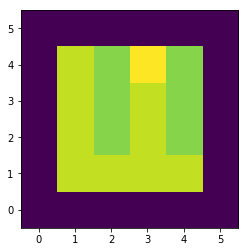

In [452]:
rwd_map = []
i = 0

for s in StateMatrix:
    if not(i % 12):
        rwd_map.append(rewardFun(s,S))
    i = i + 1

rwd_map = np.asarray(rwd_map)
rwd = rwd_map.reshape(6,6).transpose()
fig = plt.imshow(rwd,origin = "lower",vmin = -10,vmax = 1)


## Policy Iteration

In [472]:
def policyInitialize(myStates,myActions):
    
    """"
    Description: this function sets up a shortest-path based initial policy based on state and
                action settings. It will generate a path to get the robot closest to goal for each
                state. It only cares about the goal and it ignores all penalties (negative rewards)
                in the map
    
    input: myStates = class of defined states, myActions = class of defined Actions
    return: list(initial policy for each state)
    
    """
    
    S = myStates.stateMatrix
    A = myActions.Set
    
    
    # initializing policy
    p0 = {}
    rewardState = []
    p_init = []
    for s in S:
        if rewardFun(s,myStates) == 1:
            rewardState.append(s)
            p0[s] = (0,0)
    
    
    # initialize policy based on shortest path
    for s in S:
        if s not in rewardState:
            x_rwd = rewardState[0][0]
            y_rwd = rewardState[0][1]
            xs = np.copy(s[0])
            ys = np.copy(s[1])
            hs = np.copy(s[2])
            stateMove = [np.sign(x_rwd - xs),np.sign(y_rwd - ys)]
            if hs in np.array([11,0,1]):
                p0[s] = (stateMove[1],stateMove[0])
            elif hs in np.array([2,3,4]):
                p0[s] = (stateMove[0],-stateMove[1])
            elif hs in np.array([5,6,7]):
                p0[s] = (-stateMove[1],stateMove[0])
            else:
                p0[s] = (-stateMove[0],-stateMove[1])
            
            # if reward lies next to the current state but not in travel direction, go backward
            if p0[s] == (0,1) or p0[s] == (0,-1):
                p0[s] = (-1,0)
        
        p_init.append(A.index(p0[s]))
        
    return(p_init)
        

def trajectoryFun(pe,pi,s,myStates,myActions):
    
    """"
    Description: this function generates a trajectory to achieve goal based on input state
                and input policy
    
    input: pe = error probability, pi = [policy for each state], s = current state, myState
            = class of defined states, myActions = class of defined actions
    return: [trajectory for input state], plot of trajectory
    """
    
    # initialize
    S = myStates.stateMatrix
    A = myActions.Set
    state_action = {}
    s_traj = []
    i = 0
    
    # get trajectory updated for every action done based in input state
    while rewardFun(s,myStates) <= 0:
        i = S.index(s)
        state_action[s] = pi[i]
        s_new = stateUpdate(pe,s,A[pi[i]],myStates)
        s_traj.append(s_new)
        s = s_new
        
    
    # plot trajectory
    L = myStates.L
    W = myStates.W
    i = 0
    xs = []
    ys = []
    for s in s_traj:
        xs.append(s[0])
        ys.append(s[1])
        
    plt.plot(xs,ys)
    plt.axis([0,L-1,0,W-1])
    plt.grid(True)
        
    return(s_traj)


def valueFun(pe,pi,gamma,myStates,myActions):
    """
    Description: This function calculates value of each state for a given policy and discounts
    
    Input: pe = error probability, pi = list(given policy for all states), gamma = discounts
    
    Output: list(values for each state)
    """
    if gamma > 1 or gamma < 0:
        raise Exception("Invalid input. gamma should be in range[0,1])")
    
    
    S = myStates.stateMatrix
    A = myActions.Set
    V = {}
    i = 0
    for s in S:
        V[s] = 0
    
    for s in S:
        V[s] = rewardFun(s,myStates)+sum(transitionProbability(pe,s,A[pi[i]],s2,myStates)*V[s2]*gamma for s2 in S)
        i = i + 1
        
    return(V)
    
    
        
def policyIteration(pe,pol,gamma,myStates,myActions):
    """
    Description: This function use policy iteration to get an optimal policy based on initialized policy
    
    input: pe = error_probability, myStates = class of defined states, myAction = class of 
            defined actions, gamma = time_discount, epsilon = convergence threshold
    
    return: list(policy,value)
    
    Note: This function runs slowly. Please be patient
    """
    if gamma > 1 or gamma < 0:
        raise Exception("Invalid input. gamma should be in range[0,1])")
    
    
    start = timer()
    S = myStates.stateMatrix
    A = myActions.Set
    V = {}
    pi = np.copy(pol)
    for s in S:
        V[s] = 0
    
    # initialize revised policy to enter in loop
    pi_optimal = np.copy(pi)-np.copy(pi)
    ct = 0
    while any(pi - pi_optimal):
        i = 0
        pi_optimal = np.copy(pi)
        for s in S:
            value_action = []
            for a in range(0,7):
                # append value_action list for state s for all actions
                value_action.append(rewardFun(s,myStates)+gamma*sum(
                    transitionProbability(pe,s,A[a],s2,myStates)*V[s2] for s2 in S))
                    
            # set policy with highest value
            pi[i] = np.argmax(value_action)
            V[s] = max(value_action)
            i = i + 1
      
        ct = ct + 1
        print("policy iterates for %d times......" %(ct))
        
    end = timer()
    
    print("policy iteration done in %f seconds" %(end-start))
        
    return(pi_optimal,V)
                
            

initial policy setting up with action ID...
[2, 2, 3, 3, 3, 5, 5, 5, 6, 6, 6, 2, 2, 2, 3, 3, 3, 5, 5, 5, 6, 6, 6, 2, 2, 2, 3, 3, 3, 5, 5, 5, 6, 6, 6, 2, 2, 2, 3, 3, 3, 5, 5, 5, 6, 6, 6, 2, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 5, 5, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 2, 2, 3, 3, 3, 5, 5, 5, 6, 6, 6, 2, 2, 2, 3, 3, 3, 5, 5, 5, 6, 6, 6, 2, 2, 2, 3, 3, 3, 5, 5, 5, 6, 6, 6, 2, 2, 2, 3, 3, 3, 5, 5, 5, 6, 6, 6, 2, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 5, 5, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 2, 2, 3, 3, 3, 5, 5, 5, 6, 6, 6, 2, 2, 2, 3, 3, 3, 5, 5, 5, 6, 6, 6, 2, 2, 2, 3, 3, 3, 5, 5, 5, 6, 6, 6, 2, 2, 2, 3, 3, 3, 5, 5, 5, 6, 6, 6, 2, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 5, 5, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 1, 1, 1, 4, 4, 4, 4, 3, 3, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6

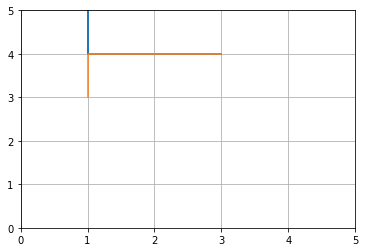

In [454]:
# initialized policy
p_init = policyInitialize(S,A)
print("initial policy setting up with action ID...")
print(p_init)
print("trajectory for robot using initialized policy: ")
s_traj = trajectoryFun(0,p_init,(1,4,6),S,A)
print(s_traj)
V = valueFun(0,p_init,0.9,S,A)
print("values along initialized trajectory: %f,%f,%f,%f,%f,%f" 
      %(V[(1,5,6)],V[(1,4,7)],V[(1,5,7)],V[(1,4,8)],V[(2,4,8)],V[(3,4,8)]))

# Optimized policy and value from policy iteration
pi_optimal,v_optimal = policyIteration(0,p_init,0.9,S,A)
print("optimized policy is: ")
print(pi_optimal)


# Optimized Trajectory
s_traj_opt = trajectoryFun(0,pi_optimal,(1,4,6),S,A)
print("trajectory for optimized policy: ")
print(s_traj_opt)
print("values for optimized policy: ")
for s in v_optimal.keys():
    if s in s_traj_opt:
        print(v_optimal[s])


## Value Iteration

In [431]:
def ValueIteration(pe,myStates,myActions,gamma,epsilon=0.5):
    
    """"
    Description: this function takes error probability, action, current state,
                next state, state map and time discount as input and returns the optimal 
                policy for each state as well as value for each state
    
    input: pe = error_probability, myStates = class of defined states, myAction = class of 
            defined actions, gamma = time_discount, epsilon = convergence threshold
    return: list(policy,value)
    
    NOTE: 1.This function runs slowly as not optimized for efficiency, please be patient
          2. epsilon is usually set to be 0.01 and default value 0.5 used for demo
    """
    
    start = timer()
    if epsilon > 0.5 or epsilon < 0.0:
        raise Exception("Invalid epsilon. Enter a value between 0 and 0.5")
        
        
    S = myStates.stateMatrix
    A = myActions.Set
    # initializae all states' values
    V = {}
    for s in S:
        V[s] = 0
    
    pi = {}
    max_value = {}
        
        
    # set a large threshold bigger than epsilon to enter in the loop
    delta = 10000
    
    # perform value iteration
    while delta > epsilon:
        
        # initialize delta to be zero, construct empty list for policy and value
        delta = 0
        policy = []
        value = []
        
        # iteration for agent being at state s in S
        for s in S:
            v = np.copy(V[s])
            value_action = []
            
            # for all actions, find value for action a at state s, sum over all future state s2
            for a in range(0,7):
                value_action.append(sum(transitionProbability(pe,s,A[a],s2,myStates)*(rewardFun(s2,myStates)+gamma*V[s2]) for s2 in S))
            V[s] = max(value_action)
            pi[s] = np.argmax(value_action)
            
            # construct policy list and value list
            policy.append(pi[s])
            value.append(V[s])
            
            # update delta for each state
            delta = max(delta,abs(v-V[s]))
    
    end = timer()
    
    print("Value iteration costs %f seconds......." %(end - start))

    return(policy,value)


def mappingState(policy,value,myStates,myActions):
    A = myActions.Set
    S = myStates.stateMatrix
    
    # convert input list to array
    V = np.asarray(value)
    P = np.asarray(policy)
    
    vmap = {}
    pmap = {}
    
    
    # mapping state with policy and value
    ct = 0
    for s in S:
        vmap[s] = V[ct]
        pmap[s] = A[P[ct]]
        ct = ct + 1
        
    return(vmap,pmap)
    
        

Value iteration costs 63.326981 seconds.......
optimal policy using value iteration is: 
[5, 2, 3, 2, 2, 6, 3, 5, 6, 5, 5, 3, 2, 2, 1, 1, 1, 6, 5, 5, 4, 4, 4, 3, 2, 2, 3, 1, 2, 6, 5, 5, 6, 4, 5, 3, 2, 2, 3, 1, 2, 6, 2, 5, 6, 4, 5, 3, 2, 5, 1, 1, 1, 3, 2, 2, 4, 4, 4, 6, 2, 5, 3, 2, 2, 3, 6, 2, 6, 5, 5, 6, 1, 2, 3, 2, 2, 6, 4, 5, 6, 5, 5, 3, 1, 1, 1, 2, 1, 4, 4, 4, 4, 5, 4, 1, 2, 1, 1, 2, 1, 4, 5, 4, 4, 5, 4, 1, 1, 2, 1, 2, 1, 6, 1, 5, 4, 5, 4, 3, 5, 4, 1, 1, 1, 1, 2, 1, 4, 4, 4, 4, 4, 5, 3, 2, 2, 3, 1, 2, 6, 5, 5, 6, 2, 2, 3, 2, 2, 6, 5, 5, 6, 2, 5, 3, 2, 2, 3, 1, 2, 6, 5, 5, 6, 1, 5, 3, 2, 2, 3, 1, 2, 6, 5, 5, 6, 1, 5, 3, 2, 2, 3, 1, 2, 6, 2, 5, 6, 1, 5, 3, 5, 5, 1, 1, 1, 3, 2, 2, 4, 4, 4, 6, 5, 5, 3, 2, 2, 3, 2, 2, 6, 2, 5, 6, 1, 1, 3, 2, 2, 4, 4, 4, 3, 2, 2, 1, 1, 1, 1, 2, 1, 4, 4, 4, 1, 2, 1, 1, 1, 1, 1, 2, 1, 4, 4, 4, 1, 2, 1, 1, 1, 1, 1, 2, 1, 4, 4, 4, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 3, 2, 2, 1, 1, 1, 3, 2, 2, 4, 2, 2, 6, 2, 5, 6, 5, 5, 3, 2, 2, 3, 2, 2, 6, 4

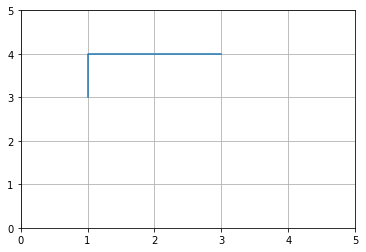

In [433]:
pi_optimal_v,v_optimal = ValueIteration(0,S,A,0.9)
print("optimal policy using value iteration is: ")
print(pi_optimal_v)

print("comparison with policy iteration: ")
print(pi_optimal_v - pi_optimal)
s_traj_v = trajectoryFun(0,pi_optimal_v,(1,4,6),S,A)





## Additional Scenario

recomputed trajectory with pe = 0.25


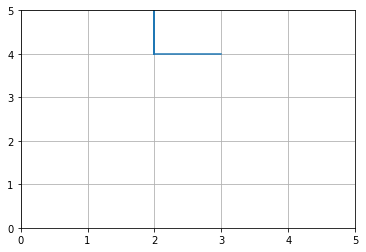

In [457]:
s_traj_v = trajectoryFun(0.25,p_init,(1,4,6),S,A)
print("recomputed trajectory with pe = 0.25")

In [481]:
def rewardFun(s,myStates):
    
    """
    Description: This function takes a certain state in state map and output the reward at that state
    
    Input: s = current state, myStates = class of defined states
    
    Return: float(reward)
    """
    
    # Extract information from states
    S = myStates.stateMatrix
    L = myStates.L
    W = myStates.W
    
    
    x_pos = s[0]
    y_pos = s[1]
    h = s[2]
    
    if x_pos < 0 or x_pos >= L or y_pos < 0 or y_pos >= W or h < 0 or h >= 12:
        raise Exception('Invalid state definition: [x,y,h] should be within range')
    
    pos = [x_pos,y_pos]
    
    if x_pos == 0 or y_pos == 0 or x_pos == (L-1) or y_pos == (W-1):
        r = -100
    elif pos == [2,2] or pos == [2,3] or pos == [2,4] or pos == [4,2] or pos == [4,3] or pos == [4,4]:
        r = -1
        
    # modification to original rewardFun
    elif pos == [3,4] and h in [6,7,8]:
        r = 1
    else: r = 0
     
    # print("reward for state (%d,%d,%d) is %d" %(s[0],s[1],s[2],r))
    return r
        
        

policy iterates for 1 times......
policy iterates for 2 times......
policy iterates for 3 times......
policy iterates for 4 times......
policy iterates for 5 times......
policy iterates for 6 times......
policy iterates for 7 times......
policy iterates for 8 times......
policy iterates for 9 times......
policy iterates for 10 times......
policy iterates for 11 times......
policy iterates for 12 times......
policy iterates for 13 times......
policy iteration done in 85.151652 seconds
recomputed trajectory using new reward function: 


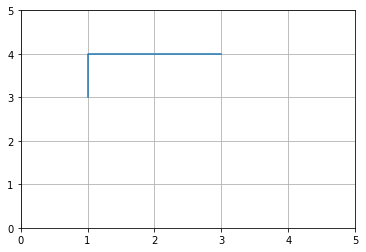

In [482]:

pi_optimal_add,v_optimal_add = policyIteration(0,p_init,0.9,S,A)
s_traj_v = trajectoryFun(0,pi_optimal_add,(1,4,6),S,A)
print("recomputed trajectory using new reward function: ")

## Description

Theoretically, both value iteration process and policy iteration process will converges the optimal policy and optimal value to the same quantities. If the number of states are not large, their computational time will not have big difference

For current reward +1 in map, it might not be intuitive that the robot will not go along a path with zero reward and then reach +1 in map, the truth is for all above situations, the time discount is less than 1 and the obstacle grid only have -1 reward in map, which will not stop the robot travelling by short-cut. If we change our obstacle grid with -100 reward in map, we will get new trajectory looks like: 

policy iterates for 1 times......
policy iterates for 2 times......
policy iterates for 3 times......
policy iterates for 4 times......
policy iterates for 5 times......
policy iterates for 6 times......
policy iterates for 7 times......
policy iterates for 8 times......
policy iterates for 9 times......
policy iterates for 10 times......
policy iteration done in 64.540024 seconds


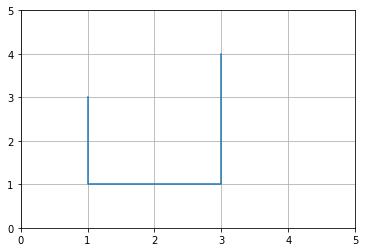

In [484]:
pi_optimal_add2,v_optimal_add2 = policyIteration(0,p_init,0.9,S,A)
s_traj_v = trajectoryFun(0,pi_optimal_add2,(1,4,6),S,A)